In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [2]:
def get_expanded_features(features):
    """Adds new features using max level, max xp of team players 
    and sum of their gold, lh, kills, deaths, items."""
    expanded_features = features
    for func, new_feature_names in \
            [(max, ['_level', '_xp']), (sum, ['_gold', '_lh', '_kills', '_deaths', '_items'])]:
        for feature in new_feature_names:
            for i, team in enumerate(['r', 'd']):
                columns = list(map(lambda num: team+str(num)+feature, range(1, 6)))
                expanded_features.loc[:, team + feature] = (features.loc[:, columns]).apply(func, axis=1)
    return expanded_features

def get_scaled_features(features):
    """Makes scaled features."""
    scaler = StandardScaler()
    scaler.fit(features)
    return scaler.transform(features)


def transform_categorial_features(features, categorial_feature_names):
    """Creates categorial features by setting 1 to heroes, that are chosen by Radiants,
    -1 to heroes, that are chosen by Dire, 0 else."""
    num_heroes = len(pd.unique(features[categorial_feature_names].values.reshape(1, -1)[0]))
    hero_max_id = max(features[categorial_feature_names].values.reshape(1, -1)[0])
    categorial_features = np.zeros((features.shape[0], hero_max_id))
    for i, match_id in enumerate(features.index):
        for p in range(5):
            categorial_features[i, features.loc[match_id, 'r%d_hero' % (p+1)]-1] = 1
            categorial_features[i, features.loc[match_id, 'd%d_hero' % (p+1)]-1] = -1
    categorial_features = categorial_features[:, (categorial_features[:]!=0).any(axis=0)]
    return categorial_features, num_heroes


def scorer(clf, features, target):
    """Makes a function-scorer with AUC_ROC value."""
    return roc_auc_score(target, clf.predict_proba(features)[:, 1])


def find_best_param(clf_type, param_range, features, target, title=None, plots=True, **kwargs):
    """Looks for parameter value of classificator that gives the best quality by
    cross-validation."""
    max_time = datetime.timedelta(0)
    quality = []
    for param in param_range:
        start_time = datetime.datetime.now()
        if clf_type == 'GradientBoostingClassifier':
            clf = GradientBoostingClassifier(n_estimators=param, random_state=241, **kwargs)
        elif clf_type == 'LogisticRegression':
            clf = LogisticRegression(penalty='l2', C=param, **kwargs)
        # make cross-validation by 5 blocks
        cv = KFold(n_splits=5, shuffle=True)
        quality.append(cross_val_score(clf, features, y=target, cv=cv, scoring=scorer).mean())
        end_time = datetime.datetime.now()
        max_time = max(end_time - start_time, max_time)
    best_param, best_quality = max(zip(param_range, quality), key=lambda el: el[1])
    
    if plots:
        # plot quality(param) dependancy
        plt.figure()
        plt.plot(param_range, quality)
        plt.title(title)
        plt.xlabel('parameter values')
        plt.ylabel('quality of classification')
        plt.grid()
        plt.show()
    
    print("\033[92m", f"Maximum elapsed time is {max_time}.")
    print("\033[92m", 'Best quality = {:.4f} of classification is achieved with param = {}.'.\
          format(best_quality, best_param))
    return best_param, best_quality

In [3]:
# get data
features = pd.read_csv('./features.csv', index_col='match_id')
target = features.loc[:, 'radiant_win'] # target variable
# drop features that are not known during first 5 minutes
features.drop(['duration', 'radiant_win', 'tower_status_radiant', 'tower_status_dire',
              'barracks_status_radiant', 'barracks_status_dire'], 
              axis='columns', inplace=True)
features.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,0,35.0,103.0,-84.0,221.0,3,4,2,2,-52.0
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,0,-20.0,149.0,-84.0,195.0,5,4,3,1,-5.0
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,1,-39.0,45.0,-77.0,221.0,3,4,3,1,13.0
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,0,-30.0,124.0,-80.0,184.0,0,4,2,0,27.0
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,0,46.0,182.0,-80.0,225.0,6,3,3,0,-16.0


In [4]:
features_with_missings = features.columns[np.where(features.count(axis=0) < features.shape[0])]
# fill missing values with nulls 
features_fill_null = features.fillna(0)
# fill missing values with large values
features_fill_large = features.fillna(10000)
# fill missing values with mean values
dict_fill = dict([
    (feature_name, np.mean(features.loc[:, feature_name])) for feature_name in features_with_missings])
features_fill_mean = features.fillna(dict_fill)

print("\033[92m", 'Columns that have missings:', ', '.join(features_with_missings))

 Columns that have missings: first_blood_time, first_blood_team, first_blood_player1, first_blood_player2, radiant_bottle_time, radiant_courier_time, radiant_flying_courier_time, radiant_first_ward_time, dire_bottle_time, dire_courier_time, dire_flying_courier_time, dire_first_ward_time


## Gradient boosting

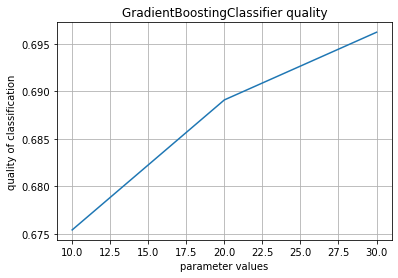

 Maximum elapsed time is 0:02:28.093349.
 Best quality = 0.6962 of classification is achieved with param = 30.


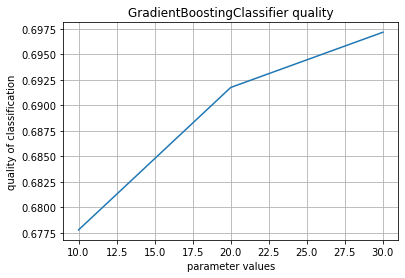

 Maximum elapsed time is 0:02:28.184644.
 Best quality = 0.6971 of classification is achieved with param = 30.


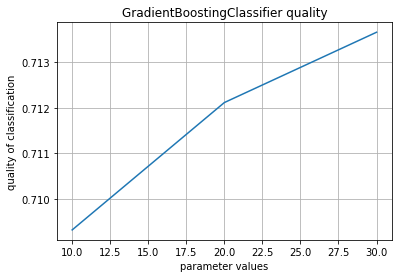

 Maximum elapsed time is 0:03:04.307698.
 Best quality = 0.7137 of classification is achieved with param = 30.


In [14]:
# GradientBoostingClassifier
# test different ways of filling missings
for features in [features_fill_null, features_fill_large, features_fill_mean]:
    # select 50% of data to decriese time
    features_part, _, target_part, _ = train_test_split(features, target, test_size=0.5, random_state=241)
    best_param, best_quality = find_best_param(
        'GradientBoostingClassifier', [10, 20, 30], features_part, target_part,
        title='GradientBoostingClassifier quality', max_depth=6)

In [15]:
# decriese time while increasing number of trees
best_param_, best_quality_ = find_best_param(
    'GradientBoostingClassifier', [60], features_part, target_part,
    plots=False, max_depth=4, max_features='log2', min_samples_leaf=5, min_impurity_decrease=0.03)

 Maximum elapsed time is 0:00:16.265174.
 Best quality = 0.7122 of classification is achieved with param = 60.


##### 1. Missing feature values 
Explanation of 2 features:<br>
`first_blood_time`: missed, if event "first blood" hadn't happen during fist 5 minutes;<br>
`radiant_flying_courier_time`: missed, if team Radiant hadn't bought any item "flying_courier" during first 5 minutes.<br>
##### 2. Target variable
`radiant_win` - column with target variable.
##### 3. Gradient boosting analise
Classification using gradient boosting with `30` trees had evaluated by `~ 3 min 4 sec`. Quality of classification, obtained with AUC_ROC scorer is `0.7137`. Best quality achieved by filling missings with `mean` value.
<br>
##### 4. Gradient boosting parameters
As we can see, increasing number of trees gives not really much increment of quality, but significantly affects the time, so 30 trees is the number of estimators that we can stop. Moreover, increasing the number of trees can lead to overfitting. <br>
To decriese time while increasing number of trees, we can decriese maximum depth with parameter `max_depth`, set other number of features to consider when looking for the best split by setting parameter `max_features`, or play with `min_samples_leaf` and `min_impurity_decrease`. As shown in the example above, changing such settings makes duration of classification `9 times faster for double growth of trees number`, howewer, quality almost unchanges.<br>
From the other side, to improve quality we can create new features based on the existing:

In [17]:
# GradientBoostingClassifier with expanded features
expanded_features = get_expanded_features(features_fill_mean)
features_part, _, target_part, _ = train_test_split(expanded_features, target, test_size=0.5, random_state=241)
best_param_, best_quality_ = find_best_param(
    'GradientBoostingClassifier', [best_param], features_part, target_part, plots=False, max_depth=6)

 Maximum elapsed time is 0:03:04.883905.
 Best quality = 0.7124 of classification is achieved with param = 30.


* Other way to improve quality could be to decriese learning rate.

## Logistic Regression

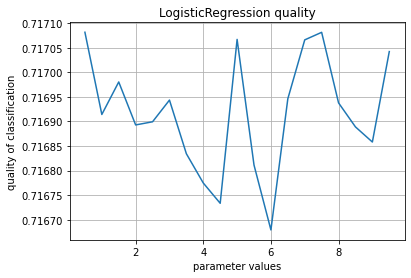

 Maximum elapsed time is 0:00:07.988928.
 Best quality = 0.7171 of classification is achieved with param = 0.5.


In [8]:
# LogisticRegression with features filled by mean values
features = features_fill_mean
scaled_features = get_scaled_features(features)
C_range = np.arange(0.5, 10, 0.5)
best_param, best_quality = find_best_param('LogisticRegression', C_range, scaled_features, target,
                                           title='LogisticRegression quality')

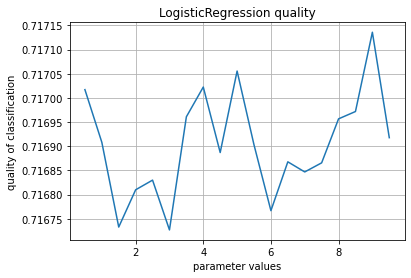

 Maximum elapsed time is 0:00:04.790939.
 Best quality = 0.7171 of classification is achieved with param = 9.0.


In [9]:
# LogisticRegression with expanded features
features = expanded_features
scaled_features = get_scaled_features(features)
C_range = np.arange(0.5, 10, 0.5)
best_param, best_quality = find_best_param('LogisticRegression', C_range, scaled_features, target,
                                           title='LogisticRegression quality')

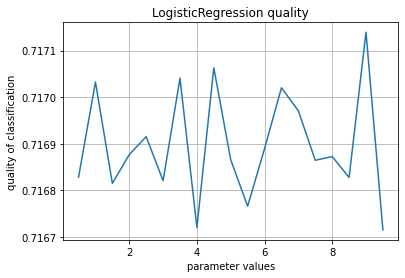

 Maximum elapsed time is 0:00:04.608056.
 Best quality = 0.7171 of classification is achieved with param = 9.0.


In [10]:
# LogisticRegression without categorial features
categorial_feature_names = [f'{team}{num}_hero' for num in range(1, 6) for team in ['r', 'd']] + ['lobby_type']
numeric_features = features.drop(categorial_feature_names, axis=1)
scaled_features = get_scaled_features(numeric_features)

best_param, best_quality = find_best_param('LogisticRegression', C_range, scaled_features, target,
                                          title='LogisticRegression quality')

 There are 108 different heroes took part in the game during first 5 minutes.


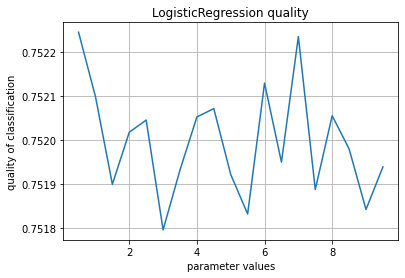

 Maximum elapsed time is 0:00:08.840554.
 Best quality = 0.7522 of classification is achieved with param = 0.5.


In [11]:
# LogisticRegression with transformed categorial features
categorial_features, num_heroes = transform_categorial_features(features, categorial_feature_names[:-1])
print("\033[92m", f'There are {num_heroes} different heroes took part in the game during first 5 minutes.')
all_features = np.hstack((numeric_features, categorial_features))
all_scaled_features = get_scaled_features(all_features)
best_param, best_quality = find_best_param('LogisticRegression', C_range, all_scaled_features, target,
                                          title='LogisticRegression quality')

#### Test the best model

In [12]:
clf = LogisticRegression(penalty='l2', C=best_param).fit(all_scaled_features, target)
index = features.index
prediction = pd.Series(clf.predict_proba(all_scaled_features)[:, 1], index=index, name='radiant_win')
if ((prediction > 0).all() & (prediction < 1).all()):
    print("\033[92m", 'Predicted values are between 0 and 1.')
print("\033[92m", 'Quality of prediction on test data is {:.4f}.'.format(scorer(clf, all_scaled_features, target)))
print("\033[92m", 'Min and max predictions are {:.4f} and {:.4f}.'.format(min(prediction), max(prediction)))

 Predicted values are between 0 and 1.
 Quality of prediction on test data is 0.7547.
 Min and max predictions are 0.0014 and 0.9989.


##### 1. Logistic Regression vs Gradient boosting
LogisticRegression with expanded features gives `0.7171` quality while GradientBoostingClassifier `0.7137`, that is probably the same. But LogisticRegression is much faster.
##### 2. Categorial features impact
LogisticRegression without categorial features givesnearly the same: `0.7171`, because not transformed catigorial features bring no information inside itself.
##### 3. Number of heroes
There are 108 different heroes took part in the game during first 5 minutes.
##### 4. Transform categirial features
After transformation of catigorial features quality raised to `0.7522`. It means that first value has grown up for ~5%. It explained by appearence new informative features that has influenced on result.
##### 5. Predicted values
Min and max predictions are `0.0014` and `0.9989`.

***
## Final prediction

In [13]:
test_features = pd.read_csv('./features_test.csv', index_col='match_id')
index = test_features.index
test_features = test_features.fillna(0)
test_features = get_expanded_features(test_features)
test_numeric_features = test_features.drop(categorial_feature_names, axis=1)
test_categorial_features, _ = transform_categorial_features(test_features, categorial_feature_names[:-1])
test_features = np.hstack((test_numeric_features, test_categorial_features))
test_features = get_scaled_features(test_features)

prediction = pd.Series(clf.predict_proba(test_features)[:, 1], index=index, name='radiant_win')
prediction.to_csv('Radiant_win_prediction.csv')
prediction

match_id
6         0.858715
7         0.755144
10        0.210463
13        0.859981
16        0.260546
            ...   
114369    0.706940
114377    0.619531
114378    0.238925
114393    0.591866
114398    0.425856
Name: radiant_win, Length: 17177, dtype: float64